<a href="https://colab.research.google.com/github/borankilic/NV_center/blob/main/nv_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NV CENTER DATA PREPROCESSING

This notebook  is designed to preprocess the voltage spectrums of NV center experiment. Throughout the notebook `ch1_volts` or `peaks` are used for the emmision spectrum of the NV centers read through the detector, `ch2_volts` or `bvals` are used for magnetic value measurements. Voltages are read using TiePie's HS5 oscilloscope and converted into csv format. You should load the csv files containing `time`,`ch1_volts` and `ch2_volts` columns. Recommended sampling settings are as below: (If you use other setting, parameters may requires some adjustment to properly work):

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import re
import seaborn as sns

## Helper Functions

In [ ]:
def normalize_array(arr):
    """
    Normalizes the input array to the given interval [min_val, max_val].

    Parameters:
    - arr: np.array, the input array to normalize.
    - min_val: float, the minimum value of the target interval.
    - max_val: float, the maximum value of the target interval.

    Returns:
    - normalized_arr: np.array, the normalized array within [min_val, max_val].
    """
    arr_min = arr.min()
    arr_max = arr.max()

    # Normalize the array to [0, 1]
    normalized_arr = (arr - arr_min) / (arr_max - arr_min)

    # Scale the array to the desired interval [min_val, max_val]
    #normalized_arr = normalized_arr * (max_val - min_val) + min_val

    return normalized_arr

# Example usage
# arr = np.random.randn(100)  # Example array
# normalized_arr = normalize_array(arr, min_val=0, max_val=1)
# print(normalized_arr)


In [ ]:


def plot_emission_spectrum(signal_array, total_duration, start_time, stop_time, second_array = None, scatter = False, linew= 0.5):
    """
    Plots the oscilloscope output of an emission spectrum over a specified time interval.

    Parameters:
    - signal_array: np.array, the emission spectrum data.
    - total_duration: float, total time duration of the signal (in seconds).
    - start_time: float, starting time of the interval to be plotted (in seconds).
    - stop_time: float, stopping time of the interval to be plotted (in seconds).
    - second_array: np.array, voltage on Helmotz coil (if provided)

    Output:
    - A Seaborn line plot for the given time window.
    """
    # Calculate the time step based on total duration and array size
    time_step = total_duration / len(signal_array)

    # Create a time array corresponding to the signal_array
    time_array = np.arange(0, total_duration, time_step)[:len(signal_array)]

    # Select the interval indices for the specified start and stop times
    start_idx = int(start_time / time_step)
    stop_idx = int(stop_time / time_step)

    # Extract the portion of the signal and time arrays for the interval
    interval_time = time_array[start_idx:stop_idx]
    interval_signal = signal_array[start_idx:stop_idx]

    # Plot the signal using Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    fig, ax1 = plt.subplots(figsize=(10, 6))
    if  not scatter:
        sns.lineplot(x=interval_time, y=interval_signal, color="blue", linewidth=linew)
    else:
        sns.scatterplot(x=interval_time, y=interval_signal, color="blue", linewidth=linew)
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Amplitude 1", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    if not np.any(second_array) == 0:

        ax2 = ax1.twinx()
        # Plot the second signal on the secondary y-axis
        ax2.set_ylabel("Amplitude 2", color="red")
        ax2.tick_params(axis='y', labelcolor="red")
        interval_second =  second_array[start_idx:stop_idx]
        sns.lineplot(x=interval_time, y=interval_second, color="red", linewidth=linew)

    plt.title(f"Emission Spectrum from {start_time}s to {stop_time}s")
    plt.show()

# Example usage
# signal_array = np.random.randn(10000)  # Example signal data
# plot_emission_spectrum(signal_array, total_duration=10, start_time=2, stop_time=4)


In [ ]:
import numpy as np
from scipy.signal import correlate

def align_time_series(emission_arrays, bvals_arrays):
    """
    Align multiple time series by shifting them according to the cross-correlation.

    Parameters:
    arrays (list of np.array): List of 1D NumPy arrays representing time series.

    Returns:
    np.array: A 2D NumPy array containing the aligned time series.
    """
    # Take the first array as the reference
    reference = emission_arrays[0]
    aligned_arrays = [reference]
    bvals_reference = bvals_arrays[0]
    aligned_bvals_arrays = [bvals_reference]

    for arr in emission_arrays[1:]:
        # Compute cross-correlation between the reference and the current array
        correlation = correlate(arr, reference,mode='same')

        # Find the shift that maximizes the cross-correlation
        shift = np.argmax(correlation) #- (len(arr) - 1)

        # Apply the shift to align the array with the reference
        if shift > 0:
            aligned = np.pad(arr, (shift, 0), mode='constant')[:len(arr)]
            bvals_aligned = np.pad(arr, (shift, 0), mode='constant')[:len(arr)]
        else:
            aligned = arr[-shift:]
            bvals_aligned = arr[-shift:]

        aligned_arrays.append(aligned)
        aligned_bvals_arrays.append(bvals_aligned)



    # Determine the minimum length after alignment and trim all arrays
    min_length = min(len(arr) for arr in aligned_arrays)
    aligned_arrays = [arr[:min_length] for arr in aligned_arrays]
    aligned_bvals_arrays = [arr[:min_length] for arr in aligned_bvals_arrays]



    return np.array(aligned_arrays), np.array(aligned_bvals_arrays)

# Example usage:
# voltage_series = [np.array([...]), np.array([...]), np.array([...]), np.array([...]), np.array([...])]
# aligned_series = align_time_series(voltage_series)



In [20]:
import numpy as np
from scipy.signal import find_peaks

def align_spectra_by_first_peak(spectra, distance_between_peaks):
    """
    Align emission spectra by shifting them such that the first peak in each spectrum aligns with the first peak in the reference spectrum.

    Parameters:
    spectra (list of np.array): List of 1D NumPy arrays representing emission spectra.
    distance_between_peaks (int): Minimum distance between peaks in samples.

    Returns:
    np.array: A 2D NumPy array containing the aligned spectra.
    """
    # Take the first spectrum as the reference
    reference = spectra[0]

    # Find the first peak in the reference spectrum
    reference_peaks, _ = find_peaks(reference, distance=distance_between_peaks)
    reference_first_peak = reference_peaks[0]

    aligned_spectra = []

    for spectrum in spectra:
        # Find the first peak in the current spectrum
        peaks, _ = find_peaks(spectrum, distance=distance_between_peaks)
        if len(peaks) == 0:
            raise ValueError("No peaks found in the spectrum.")

        first_peak = peaks[0]

        # Calculate the shift needed to align the first peak with the reference first peak
        shift = reference_first_peak - first_peak

        # Apply the shift to the spectrum
        if shift > 0:
            aligned_spectrum = np.pad(spectrum, (shift, 0), mode='constant')[:len(spectrum)]
        else:
            aligned_spectrum = np.pad(spectrum, (0, -shift), mode='constant')[-shift:]

        aligned_spectra.append(aligned_spectrum)

    # Determine the minimum length after alignment and trim all spectra
    min_length = min(len(spectrum) for spectrum in aligned_spectra)
    aligned_spectra = [spectrum[:min_length] for spectrum in aligned_spectra]

    return np.array(aligned_spectra)

# Example usage:
# spectra = [np.array([...]), np.array([...]), ...]  # List of spectra arrays
# aligned_spectra = align_spectra_by_first_peak(spectra, distance_between_peaks=100)


In [21]:
import numpy as np
from scipy.signal import find_peaks

def find_complete_double_peaks(spectrum, distance_between_peaks, valley_threshold=0.5):
    """
    Finds the first two complete double peaks (two consecutive peaks with a valley between them
    that drops below a certain percentage of the average peak height).

    Parameters:
    spectrum (np.array): 1D NumPy array representing an emission spectrum.
    distance_between_peaks (int): Minimum distance between peaks in samples.
    valley_threshold (float): The fraction of the average peak height that the valley must drop below
                              to consider the double peak complete (default is 0.5).

    Returns:
    tuple: Indices of the two peaks that form the first complete double peak.
    """
    # Find all peaks in the spectrum
    peaks, _ = find_peaks(spectrum, distance=distance_between_peaks)

    for i in range(len(peaks) - 1):
        # Get the heights of the two consecutive peaks
        peak1, peak2 = peaks[i], peaks[i + 1]
        peak1_height, peak2_height = spectrum[peak1], spectrum[peak2]

        # Get the valley between the two peaks
        valley = min(spectrum[peak1:peak2])

        # Calculate the average height of the two peaks
        avg_peak_height = (peak1_height + peak2_height) / 2

        # Check if the valley is below the specified threshold of the average peak height
        if valley < avg_peak_height * valley_threshold:
            # Return the two peaks if they form a complete double peak
            return (peak1, peak2)

    raise ValueError("No complete double peak found in the spectrum.")

def align_spectra_by_complete_double_peaks(spectra, distance_between_peaks, valley_threshold=0.5):
    """
    Align emission spectra by shifting them such that the first two complete double peaks
    in each spectrum align with the same peaks in the reference spectrum.

    Parameters:
    spectra (list of np.array): List of 1D NumPy arrays representing emission spectra.
    distance_between_peaks (int): Minimum distance between peaks in samples.
    valley_threshold (float): The fraction of the average peak height that the valley must drop below
                              to consider the double peak complete (default is 0.5).

    Returns:
    np.array: A 2D NumPy array containing the aligned spectra.
    """
    # Take the first spectrum as the reference
    reference = spectra[0]

    # Find the first complete double peak in the reference spectrum
    reference_first_complete_peaks = find_complete_double_peaks(reference, distance_between_peaks, valley_threshold)

    aligned_spectra = []

    for spectrum in spectra:
        # Find the first complete double peak in the current spectrum
        first_complete_peaks = find_complete_double_peaks(spectrum, distance_between_peaks, valley_threshold)

        # Calculate the shifts needed to align the two peaks
        shift_first_peak = reference_first_complete_peaks[0] - first_complete_peaks[0]
        shift_second_peak = reference_first_complete_peaks[1] - first_complete_peaks[1]

        # Take the average of the two shifts to balance the alignment
        avg_shift = (shift_first_peak + shift_second_peak) // 2

        # Apply the average shift to the spectrum
        if avg_shift > 0:
            aligned_spectrum = np.pad(spectrum, (avg_shift, 0), mode='constant', constant_values=spectrum[0])[:len(spectrum)]
        else:
            aligned_spectrum = np.pad(spectrum, (0, -avg_shift), mode='constant', constant_values=spectrum[0])[-avg_shift:]

        aligned_spectra.append(aligned_spectrum)

    # Determine the minimum length after alignment and trim all spectra
    min_length = min(len(spectrum) for spectrum in aligned_spectra)
    aligned_spectra = [spectrum[:min_length] for spectrum in aligned_spectra]

    return np.array(aligned_spectra)

# Example usage:
# spectra = [np.array([...]), np.array([...]), ...]  # List of spectra arrays
# aligned_spectra = align_spectra_by_complete_double_peaks(spectra, distance_between_peaks=100, valley_threshold=0.5)


In [ ]:
import numpy as np
from scipy.signal import find_peaks

def crop_before_first_double_peak(spectrum, distance_between_peaks, valley_threshold=0.5):
    """
    Crop out the portion of the spectrum before the first double peak with a valley.

    A double peak is defined as two consecutive peaks with a valley between them
    that drops below a certain percentage of the average peak height.

    Parameters:
    spectrum (np.array): 1D NumPy array representing the emission spectrum.
    distance_between_peaks (int): Minimum distance between peaks in samples.
    valley_threshold (float): The fraction of the average peak height that the valley must drop below
                              to consider the double peak complete (default is 0.5).

    Returns:
    np.array: Cropped spectrum starting from the first peak of the first double peak.
    """
    # Find all peaks in the spectrum
    peaks, _ = find_peaks(spectrum, distance=distance_between_peaks)

    for i in range(len(peaks) - 1):
        # Get the heights of the two consecutive peaks
        peak1, peak2 = peaks[i], peaks[i + 1]
        peak1_height, peak2_height = spectrum[peak1], spectrum[peak2]

        # Get the valley between the two peaks
        valley = min(spectrum[peak1:peak2])

        # Calculate the average height of the two peaks
        avg_peak_height = (peak1_height + peak2_height) / 2

        # Check if the valley is below the specified threshold of the average peak height
        if valley < avg_peak_height * valley_threshold:
            # Return the cropped spectrum starting from the first peak of the double peak
            return spectrum[peak1:]

    raise ValueError("No complete double peak found in the spectrum.")

# Example usage:
# spectrum = np.array([...])  # A single spectrum array
# cropped_spectrum = crop_before_first_double_peak(spectrum, distance_between_peaks=100, valley_threshold=0.5)


In [ ]:
import numpy as np

def crop_spectrum_around_valley(spectra, bvals, min_consecutive_points, threshold_ratio=0.3):
    """
    Crop each spectrum starting from the average of the points where the voltage first drops
    to 30% of the maximum value and then rises back to 30%, but only if the voltage stays
    below the threshold for a minimum time (min_consecutive_time).

    Parameters:
    spectra (list of np.array): List of 1D NumPy arrays representing emission spectra.
    threshold_ratio (float): The ratio of the maximum value to define the threshold
                             (default is 0.3, which means 30% of the maximum value).
    min_consecutive_time (float): Minimum time the voltage should stay below the threshold value.
    time_step (float): Time between consecutive points in the spectrum.

    Returns:
    list of np.array: A list of cropped spectra, each starting from the average of the two points
                      where the value first drops and then rises back to the threshold.
    """
    cropped_spectra = []
    cropped_bvals = []

    for idx in range(len(spectra)):
        max_value = np.max(spectra[idx])  # Find the maximum value in the spectrum
        threshold_value = threshold_ratio * max_value  # Set the threshold (30% of max)

        # Find the points where the spectrum drops to the threshold
        below_threshold_indices = np.where(spectra[idx] <= threshold_value)[0]

        if len(below_threshold_indices) == 0:
            raise ValueError("No points found below the threshold in this spectrum.")

        # Traverse to find the first drop and corresponding rise back to threshold
        for i in range(len(below_threshold_indices) - min_consecutive_points):
            first_drop_index = below_threshold_indices[i]

            # Check if it stays below the threshold for the required number of points
            if (below_threshold_indices[i + min_consecutive_points - 1] - first_drop_index) == min_consecutive_points - 1:
                # Find the point where it rises back above the threshold after the drop
                above_threshold_indices = np.where(spectra[idx][first_drop_index + min_consecutive_points:] >= threshold_value)[0]

                if len(above_threshold_indices) == 0:
                    raise ValueError("No points found where the spectrum rises back above the threshold.")

                # Get the index where the spectrum rises back to the threshold after the drop
                rise_back_index = first_drop_index + min_consecutive_points + above_threshold_indices[0]

                # Calculate the average index of the drop and rise
                average_index = (first_drop_index + rise_back_index) // 2

                # Crop the spectrum starting from the average index
                cropped_spectrum = spectra[idx][average_index:]
                cropped_bval = bvals[idx][average_index:]
                cropped_spectra.append(cropped_spectrum)
                cropped_bvals.append(cropped_bval)

                # Exit after finding the first valid crop
                break
        else:
            raise ValueError("No valley found that stays below the threshold for the minimum required time.")

    return cropped_spectra, cropped_bvals

# Example usage:
# spectra = [np.array([...]), np.array([...]), ...]  # List of spectra arrays
# cropped_spectra = crop_spectrum_around_valley(spectra, threshold_ratio=0.3, min_consecutive_time=0.01, time_step=0.001)


In [ ]:
import numpy as np
from scipy.signal import find_peaks

def align_spectra_and_magnetic_values(spectra, magnetic_values, distance_between_peaks, reference_index = 0):
    """
    Align a list of emission spectra by shifting them such that the first two main peaks
    in each spectrum align with the corresponding peaks in a reference spectrum. Additionally,
    apply the same shift to the corresponding magnetic values.

    Parameters:
    spectra (list of np.array): List of 1D NumPy arrays representing emission spectra.
    magnetic_values (list of np.array): List of 1D NumPy arrays representing magnetic values.
    reference_index (int): Index of the spectrum to be used as the reference.
    distance_between_peaks (int): Minimum distance between peaks in samples for peak detection.

    Returns:
    tuple: (aligned_spectra, aligned_magnetic_values) where both are lists of aligned arrays.
    """
    # Take the reference spectrum
    reference_spectrum = spectra[reference_index]

    # Find the first two peaks in the reference spectrum
    reference_peaks, _ = find_peaks(reference_spectrum, distance=distance_between_peaks, height=0.5*max(reference_spectrum))
    if len(reference_peaks) < 2:
        raise ValueError("Less than two peaks found in the reference spectrum.")

    reference_peak1, reference_peak2 = reference_peaks[:2]  # First two peaks in reference

    aligned_spectra = []
    aligned_magnetic_values = []

    for i, (spectrum, magnetic) in enumerate(zip(spectra, magnetic_values)):
        # Find the first two peaks in the current spectrum
        peaks, _ = find_peaks(spectrum, distance=distance_between_peaks, height=0.5*max(spectrum))
        if len(peaks) < 2:
            raise ValueError(f"Less than two peaks found in spectrum {i}.")

        peak1, peak2 = peaks[:2]  # First two peaks in the current spectrum

        # Calculate the shift needed to align the first two peaks with the reference peaks
        shift1 = reference_peak1 - peak1


        # Use the average shift between the two peaks
        avg_shift = shift1

        # Apply the shift to the spectrum
        if avg_shift > 0:
            aligned_spectrum = np.pad(spectrum, (avg_shift, 0), mode='constant',constant_values=spectrum[0])[:len(spectrum)]
            aligned_magnetic = np.pad(magnetic, (avg_shift, 0), mode='constant',constant_values=magnetic[0])[:len(magnetic)]
        else:
            aligned_spectrum = np.pad(spectrum, (0, -avg_shift), mode='constant',constant_values=spectrum[0])[-avg_shift:]
            aligned_magnetic = np.pad(magnetic, (0, -avg_shift), mode='constant',constant_values=magnetic[0])[-avg_shift:]

        aligned_spectra.append(aligned_spectrum)
        aligned_magnetic_values.append(aligned_magnetic)

    return aligned_spectra, aligned_magnetic_values

# Example usage:
# spectra = [np.array([...]), np.array([...]), ...]  # List of spectra arrays
# magnetic_values = [np.array([...]), np.array([...]), ...]  # List of magnetic field arrays
# aligned_spectra, aligned_magnetic_values = align_spectra_and_magnetic_values(spectra, magnetic_values, reference_index=0, distance_between_peaks=100)


In [ ]:
import numpy as np
from scipy.signal import find_peaks

def find_double_peak_midpoints(spectrum, distance_between_peaks=10):
    """
    Finds the midpoints of two double peaks in the spectrum.

    Parameters:
    spectrum (np.array): 1D NumPy array representing the spectrum.
    distance_between_peaks (int): Minimum distance between peaks.

    Returns:
    float: The distance between the midpoints of two double peaks.
    """
    # Find all peaks in the spectrum
    peaks, _ = find_peaks(spectrum, distance=distance_between_peaks)

    if len(peaks) < 4:
        raise ValueError("Less than 4 peaks found, unable to find two double peaks.")

    # Assume the first two sets of double peaks
    double_peaks = []
    for i in range(0, len(peaks)-1, 2):
        if i + 1 < len(peaks):
            double_peaks.append((peaks[i], peaks[i + 1]))
            if len(double_peaks) == 2:
                break

    # Calculate midpoints of the first two double peaks
    midpoint_1 = (double_peaks[0][0] + double_peaks[0][1]) / 2
    midpoint_2 = (double_peaks[1][0] + double_peaks[1][1]) / 2

    # Calculate and return the distance between the midpoints
    distance_between_midpoints = abs(midpoint_2 - midpoint_1)

    return distance_between_midpoints

# Example usage:
# spectrum = np.array([...])  # Your spectrum data
# distance = find_double_peak_midpoints(spectrum, distance_between_peaks=10)
# print("Distance between double peak midpoints:", distance)


In [ ]:
import numpy as np

def linearize_spectrum(spectrum):
    """
    Linearize the spectrum based on its maximum and minimum points.

    Parameters:
    spectrum (np.array): 1D NumPy array representing the spectrum.

    Returns:
    np.array: A 1D array of the same size as the input spectrum, containing values
              on the line between the minimum and maximum points of the spectrum.
    """
    # Find the index and value of the minimum and maximum points in the spectrum
    min_index = np.argmin(spectrum)
    max_index = np.argmax(spectrum)

    min_value = spectrum[min_index]
    max_value = spectrum[max_index]

    # Calculate the slope (m) of the line between the minimum and maximum points
    slope = (max_value - min_value) / (max_index - min_index)

    # Generate a linear line connecting the min and max points
    linear_spectrum = np.zeros_like(spectrum)

    # Linear interpolation between the min and max points
    for i in range(len(spectrum)):
            linear_spectrum[i] = max_value - slope * (i - max_index)

    return linear_spectrum

# Example usage:
# spectrum = np.array([...])  # Your spectrum data
# linear_spectrum = linearize_spectrum(spectrum)
# print(linear_spectrum)


# Import DATA

In [ ]:
# This cell imports all the csv files containing emmission spectrum data.

peak_list = []
B_vals_list = []
num_of_data_files = 20
for idx in range(1,num_of_data_files+1):
    data_file = rf"05_09_{idx}.csv" # ENTER THE PATH THAT IS COMMON TO ALL FILES FROM THE SAME EXPERIMENT. KEEP THE FORMAT SAME.
    df = pd.read_csv(data_file, encoding='latin-1',sep=';')
    df.drop(0,axis=0,inplace=True)

    convert_to_float = lambda s: float(s.replace(',', '.'))  # Replaces ',' sign with '.' for the correctness of notation

    ch1_volts = df['Ch1']
    ch2_volts = df['Ch2']
    ch1_volts = np.array(list(map(convert_to_float, ch1_volts)), dtype=np.float64)
    ch1_volts = normalize_array(-ch1_volts)
    ch2_volts = np.array(list(map(convert_to_float, ch2_volts)), dtype=np.float64)
    peak_list.append(ch1_volts)
    B_vals_list.append(ch2_volts)


    # Define Duration and Sample Num Accordingly
    df['Relative time'] = pd.to_numeric(df['Relative time'], errors='coerce')
    duration = np.round(np.array(df['Relative time'])[-1])  #(seconds)
    num_points = len(ch1_volts)



<ipython-input-13-9bd7fa2e531e>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file, encoding='latin-1',sep=';')
<ipython-input-13-9bd7fa2e531e>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file, encoding='latin-1',sep=';')
<ipython-input-13-9bd7fa2e531e>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file, encoding='latin-1',sep=';')
<ipython-input-13-9bd7fa2e531e>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file, encoding='latin-1',sep=';')
<ipython-input-13-9bd7fa2e531e>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file, encoding='latin-1',sep=';')
<ipython-input-13-9bd7fa2e531e>:8: 

2314.5


<Figure size 1000x600 with 0 Axes>

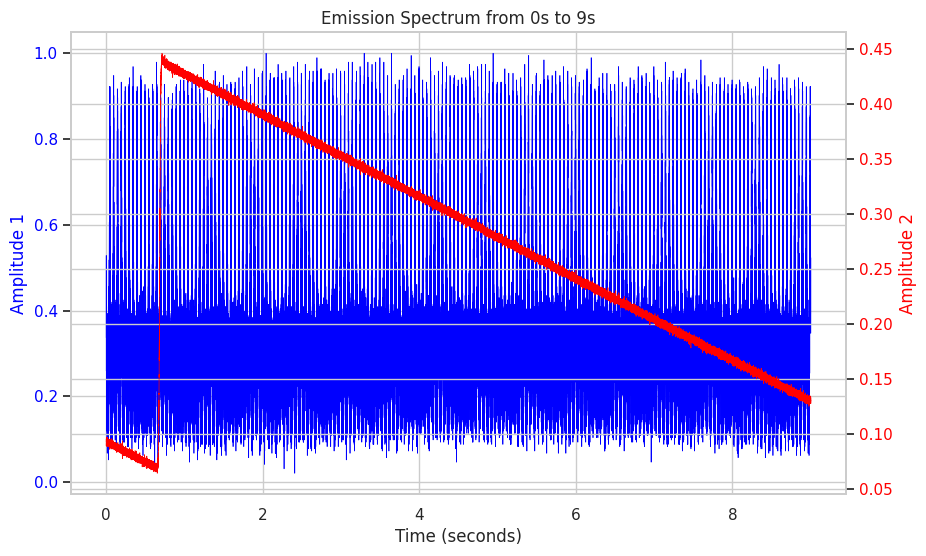

In [ ]:
distance_btwn_peaks = find_double_peak_midpoints(peak_list[0], 1000)
print(distance_btwn_peaks)
plot_emission_spectrum(peak_list[0], 10,0,9,B_vals_list[0])

## Crop and Concetanate the Signal
Ensure that voltage of the Helmoltz coil forms a nice linear pattern
Select every peak and divide them. Then append them onto a np.array.


<Figure size 1000x600 with 0 Axes>

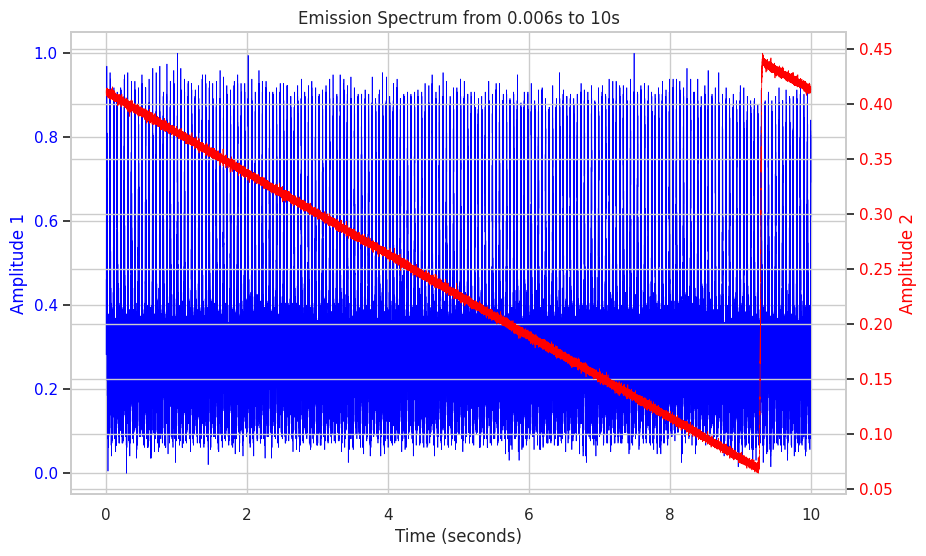

In [22]:
# Crops the part where magnetic field drops suddenly when current given the Helmoltz coils are in the ramp form.
#This is crucial since considering the peak where B abruptly changes will create an outlier in the test data
crop_stop = 1000  #how many data points after the max value of the spectrum will the  cropping stop
cropped_length = 4000
cropped_peaks_list = []
cropped_bvals_list = []
for i in range(len(B_vals_list)):
    crop_stop= int(np.where(B_vals_list[i]==max(B_vals_list[i]))[0][0])+ crop_stop
    crop_start = crop_stop-cropped_length
    peak_cropped = np.concatenate([peak_list[i][crop_stop:] ,peak_list[i][:crop_start]])
    bvals_cropped = np.concatenate([B_vals_list[i][crop_stop:] , B_vals_list[i][:crop_start]])
    cropped_peaks_list.append(peak_cropped)
    cropped_bvals_list.append(bvals_cropped)

plot_emission_spectrum(cropped_peaks_list[1], 10, 0.006, 10, second_array=cropped_bvals_list[1])

## Moving Average Filter

<Figure size 1000x600 with 0 Axes>

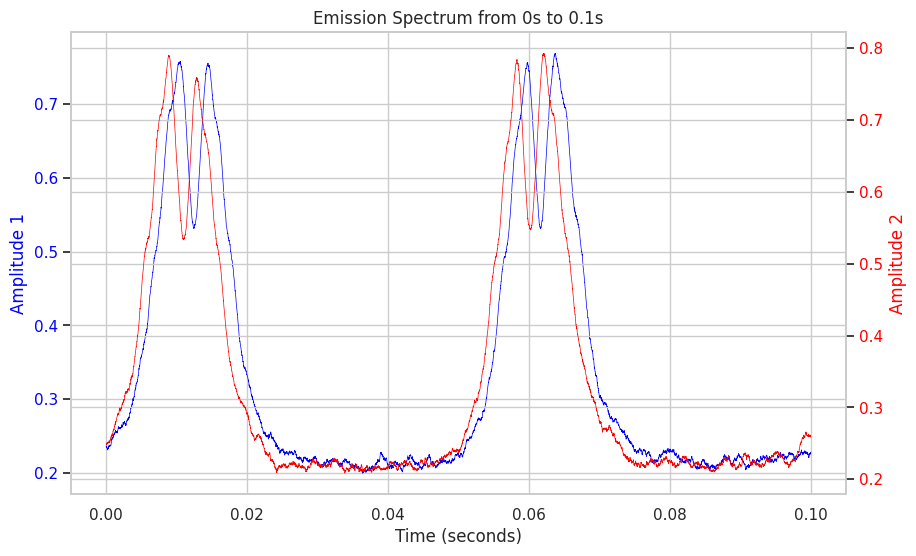

In [23]:
# First try to deternmine an adequate filter size by manually changing the size of the filter and isnpecting the plot
# PLEASE ENTER BOTH EVEN OR BOTH ODD VALUES FOR THE FILTER SIZES

peaks_filter_size = 100
bvals_filter_size = 400
interpolated_peaks_list = []
interpolated_bvals_list = []
for i in range(len(cropped_peaks_list)):
    moving_ave_filter_1 = (1/peaks_filter_size)*np.ones(peaks_filter_size)
    moving_ave_filter_2 = (1/bvals_filter_size)*np.ones(bvals_filter_size)
    ch1_volts_interpolated = np.convolve(cropped_peaks_list[i], moving_ave_filter_1)[int((peaks_filter_size+bvals_filter_size)/2):-int((peaks_filter_size+bvals_filter_size)/2)]
    ch2_volts_interpolated = np.convolve(cropped_bvals_list[i], moving_ave_filter_2)[bvals_filter_size:-bvals_filter_size]
    interpolated_peaks_list.append(ch1_volts_interpolated)
    interpolated_bvals_list.append(ch2_volts_interpolated)
plot_emission_spectrum(interpolated_peaks_list[3] , 10, 0,0.1, interpolated_peaks_list[1])

<Figure size 1000x600 with 0 Axes>

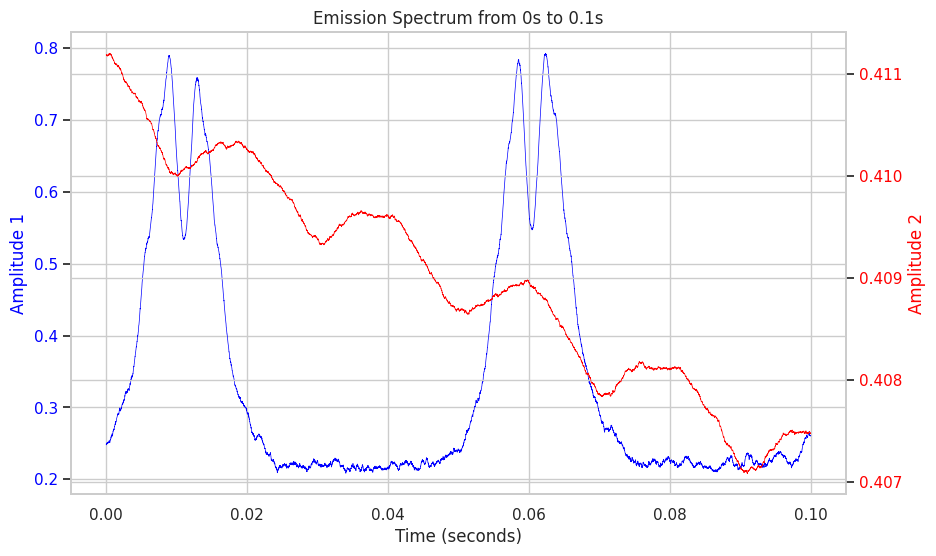

In [24]:
plot_emission_spectrum(interpolated_peaks_list[1], 10, 0, 0.1, interpolated_bvals_list[1])

<Figure size 1000x600 with 0 Axes>

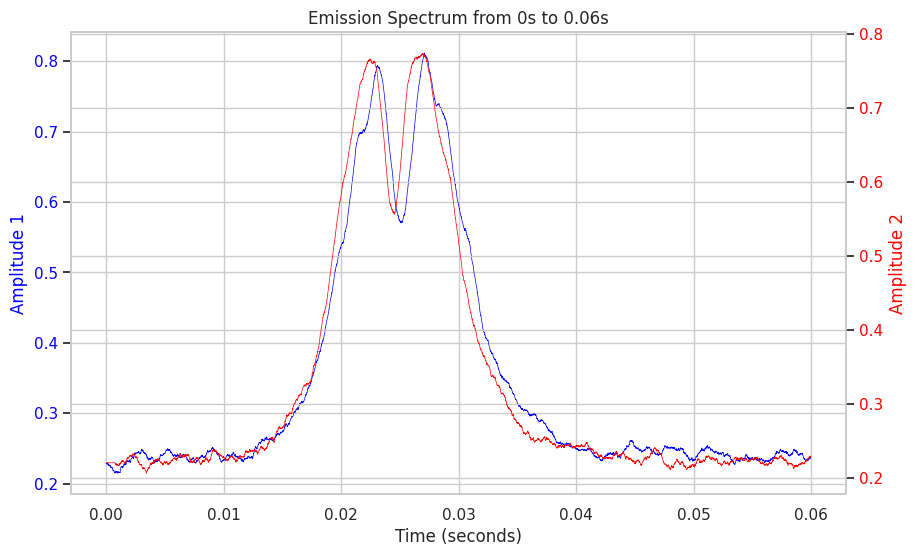

In [39]:
# ALIGN PEAKS
int_peak_list_cropped, int_bvals_list_cropped = crop_spectrum_around_valley(interpolated_peaks_list, interpolated_bvals_list,2000)
int_peak_list_algnd, int_bvals_list_algnd = align_spectra_and_magnetic_values(int_peak_list_cropped, int_bvals_list_cropped, 500)
plot_emission_spectrum(int_peak_list_algnd[0], 10, 0, 0.06, int_peak_list_algnd[7])


## Low Pass Filter - Butterworth

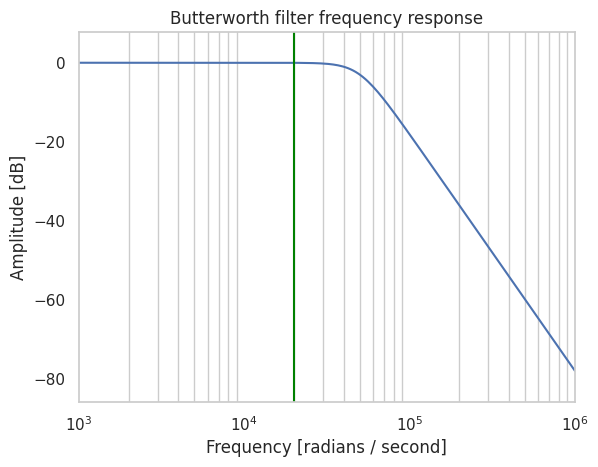

In [26]:
# THIS CELL IS JUST FOR VISUALIZING THE LOWPASS FILTER

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
b, a = signal.butter(3, 50000, analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(20000, color='green') # cutoff frequency
plt.show()

<Figure size 1000x600 with 0 Axes>

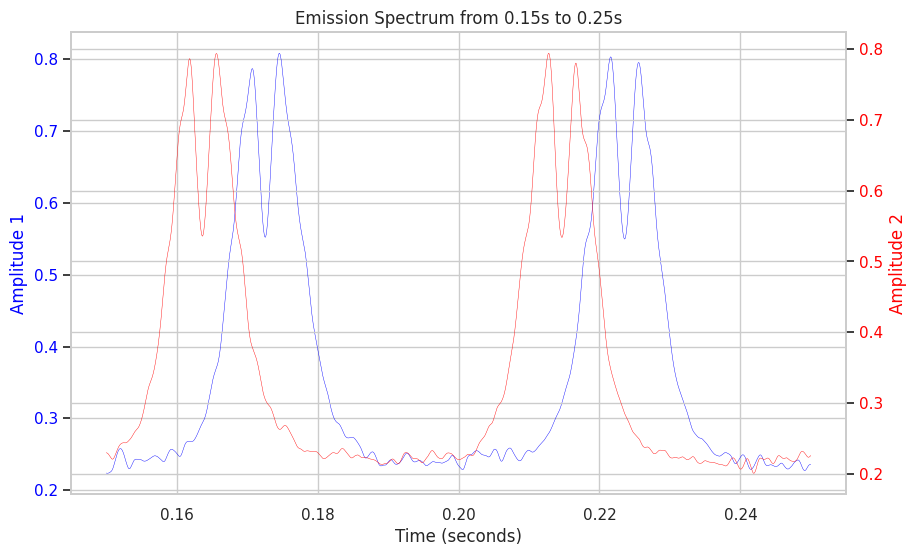

In [31]:
# Parameters of the Butterworth filter
filter_order = 4
cutoff_freq = 5000

# Initialize the filter
sos = signal.butter(filter_order, cutoff_freq, 'lp', fs=num_points, output='sos')


lp_peaks_list = []
lp_bvals_list = []
for i in range(len(cropped_peaks_list)):
    ch1_volts_lp = signal.sosfilt(sos, cropped_peaks_list[i])
    ch2_volts_lp= signal.sosfilt(sos, cropped_bvals_list[i])
    lp_peaks_list.append(ch1_volts_lp)
    lp_bvals_list.append(ch2_volts_lp)
plot_emission_spectrum(lp_peaks_list[0], 10, 0.15, 0.25, lp_peaks_list[1], linew=0.3)

<Figure size 1000x600 with 0 Axes>

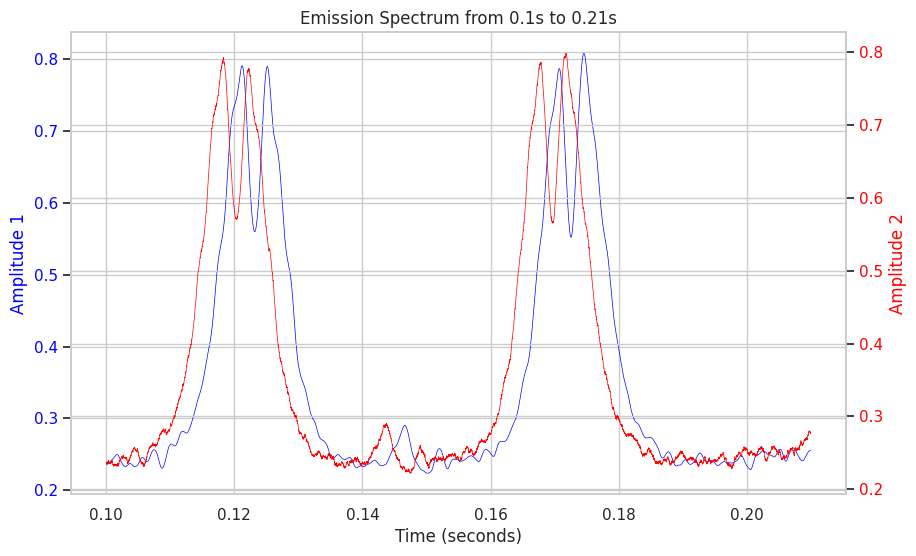

In [32]:
plot_emission_spectrum(lp_peaks_list[0] , 10, 0.1, 0.21, interpolated_peaks_list[0])

<Figure size 1000x600 with 0 Axes>

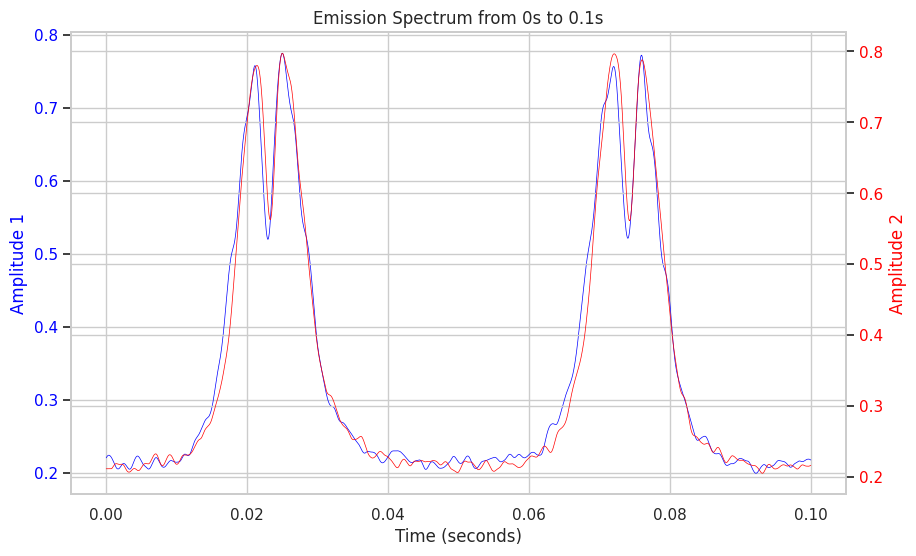

In [34]:
# ALIGN PEAKS
lp_peak_list_cropped, lp_bvals_list_cropped = crop_spectrum_around_valley(lp_peaks_list, lp_bvals_list,1000) # You might need to adjust min consecutive points parameter
lp_peak_list_algnd, lp_bvals_list_algnd = align_spectra_and_magnetic_values(lp_peak_list_cropped, lp_bvals_list_cropped, 500)
plot_emission_spectrum(lp_peak_list_algnd[4], 10, 0, 0.1, lp_peak_list_algnd[9])


# Fourier Transorm


c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


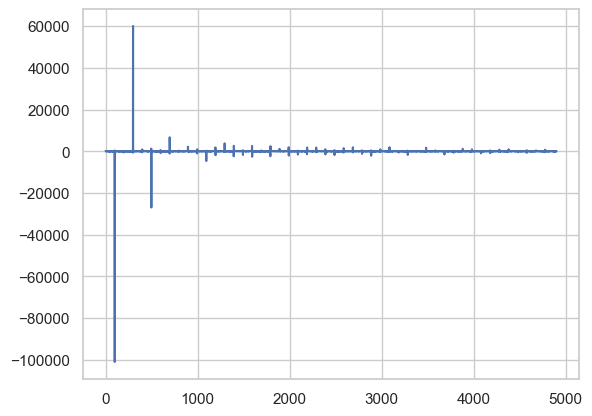

In [ ]:
fft = np.fft.fft(cropped_peaks_list[0])

plt.plot(fft[100:5000])


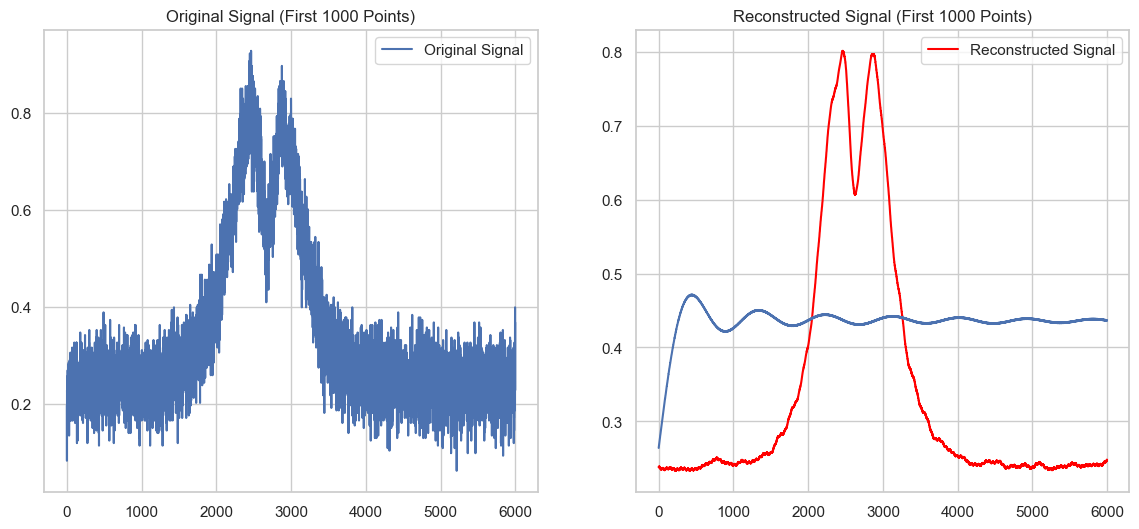

In [ ]:

# Step 1: Create or load your signal
signal_1 = cropped_peaks_list[0]  # Example signal with 990000 data points
signal_2 = cropped_bvals_list[0]
# Step 2: Perform FFT to deconstruct the signal
fft_signal_1 = np.fft.fft(signal_1)
fft_signal_2 = np.fft.fft(signal_2)
# Step 3: Get the frequencies corresponding to the FFT components
frequencies_1 = np.fft.fftfreq(len(signal_1))
frequencies_12 = np.fft.fftfreq(len(signal_2))
# Step 4: Define a threshold and filter the frequencies

threshold_1 = 500 # Example threshold, you can adjust this
threshold_2 = 50

filtered_fft_1 = np.where(np.abs(fft_signal_1) > threshold_1, fft_signal_1, 0)
filtered_fft_2 = np.where(np.abs(fft_signal_2) > threshold_2, fft_signal_2, 0)

# Step 5: Perform Inverse FFT to reconstruct the signal using filtered components
reconstructed_signal_1 = np.fft.ifft(filtered_fft_1).real
reconstructed_signal_2 = np.fft.ifft(filtered_fft_2).real
# Plotting the original and reconstructed signals for comparison
plt.figure(figsize=(14, 6))

# Original signal plot
plt.subplot(1, 2, 1)
plt.plot(signal_1[:6000], label='Original Signal')
plt.title('Original Signal (First 1000 Points)')
plt.legend()

# Reconstructed signal plot
plt.subplot(1, 2, 2)
plt.plot(reconstructed_signal_1[:6000], label='Reconstructed Signal', color='red')
plt.plot(reconstructed_signal_2[:6000] )
plt.title('Reconstructed Signal (First 1000 Points)')
plt.legend()

plt.show()


In [ ]:
# Apply Fourier transform on all of the spectra

# Define a threshold and filter the frequencies
threshold_1 = 500 # Threshols below which frequency components will be thrown out
threshold_2 = 500

fft_peaks_list = []
fft_bvals_list = []
for i in range(len(cropped_peaks_list)):
    fft_signal_1 = np.fft.fft(cropped_peaks_list[i])
    fft_signal_2 = np.fft.fft(cropped_bvals_list[i])
    #Get the frequencies corresponding to the FFT components
    frequencies_1 = np.fft.fftfreq(len(signal_1))
    frequencies_12 = np.fft.fftfreq(len(signal_2))

    filtered_fft_1 = np.where(np.abs(fft_signal_1) > threshold_1, fft_signal_1, 0)
    filtered_fft_2 = np.where(np.abs(fft_signal_2) > threshold_2, fft_signal_2, 0)

    #Perform Inverse FFT to reconstruct the signal using filtered components
    reconstructed_signal_1 = np.fft.ifft(filtered_fft_1).real
    reconstructed_signal_2 = np.fft.ifft(filtered_fft_2).real


    fft_peaks_list.append(reconstructed_signal_1)
    fft_bvals_list.append(reconstructed_signal_2)

<Figure size 1000x600 with 0 Axes>

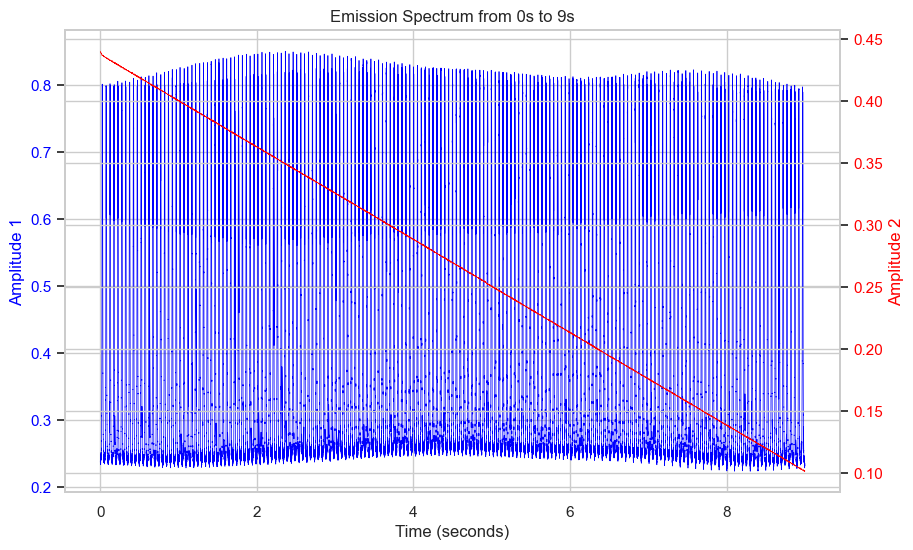

In [ ]:
plot_emission_spectrum(fft_peaks_list[0], 9.89, 0, 9, interpolated_bvals_list[0])

<Figure size 1000x600 with 0 Axes>

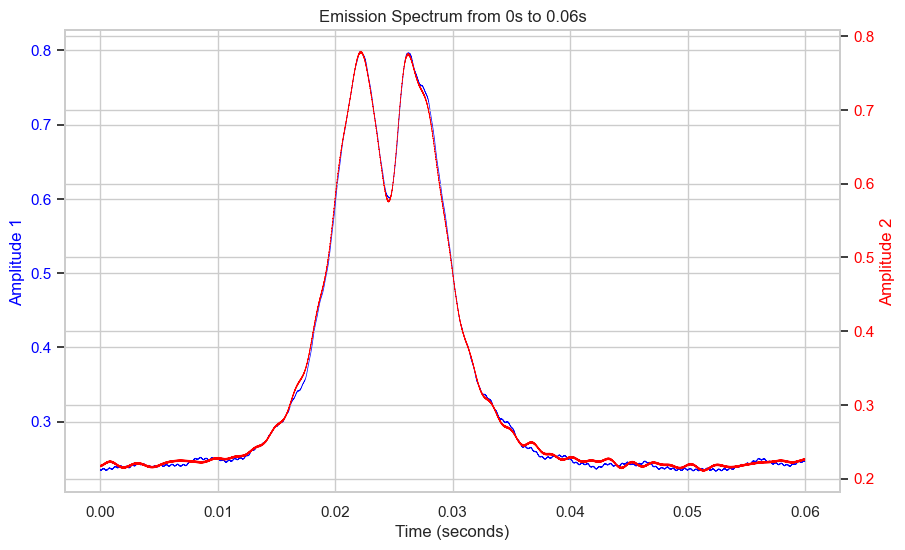

In [ ]:
# ALIGN PEAKS
fft_peak_list_cropped, fft_bvals_list_cropped = crop_spectrum_around_valley(fft_peaks_list, fft_bvals_list,2000)
fft_peak_list_algnd, fft_bvals_list_algnd = align_spectra_and_magnetic_values(fft_peak_list_cropped, fft_bvals_list_cropped, 500)
plot_emission_spectrum(fft_peak_list_algnd[0], 10, 0, 0.06, fft_peak_list_algnd[4])

In [42]:
type(round(distance_btwn_peaks*2/1000)*1000)

int

# Divide into Peaks

In [45]:
peaks = []
B_values = []

dist = round(distance_btwn_peaks*2/1000)*1000

for j in range(len(int_peak_list_algnd)):
    for i in range(0, 100000):
        try:
            p1, t1=  int_peak_list_algnd[j][i*dist : (i+1)*dist], (i*int(dist/2))
            #B1 = B_max - (B_max-B_min)*(t1/10)
            B1 = int_bvals_list_algnd[j][int(t1)]
            if len(p1) == dist:
                peaks.append(p1)
                B_values.append(B1)
        except IndexError:
            break
B_values = np.array(B_values)
peaks =np.array(peaks)
print(len(peaks))
'''
try:
    B_values = np.array(B_values)
    peaks =np.vstack(peaks)
except ValueError:
    peaks = peaks[:-1]
    B_values = B_values[:-1]
B_values = np.array(B_values)
peaks =np.vstack(peaks)
print(peaks.shape)'''

3680


'\ntry:\n    B_values = np.array(B_values)\n    peaks =np.vstack(peaks)\nexcept ValueError:\n    peaks = peaks[:-1]\n    B_values = B_values[:-1]\nB_values = np.array(B_values)\npeaks =np.vstack(peaks)\nprint(peaks.shape)'

<Figure size 1000x600 with 0 Axes>

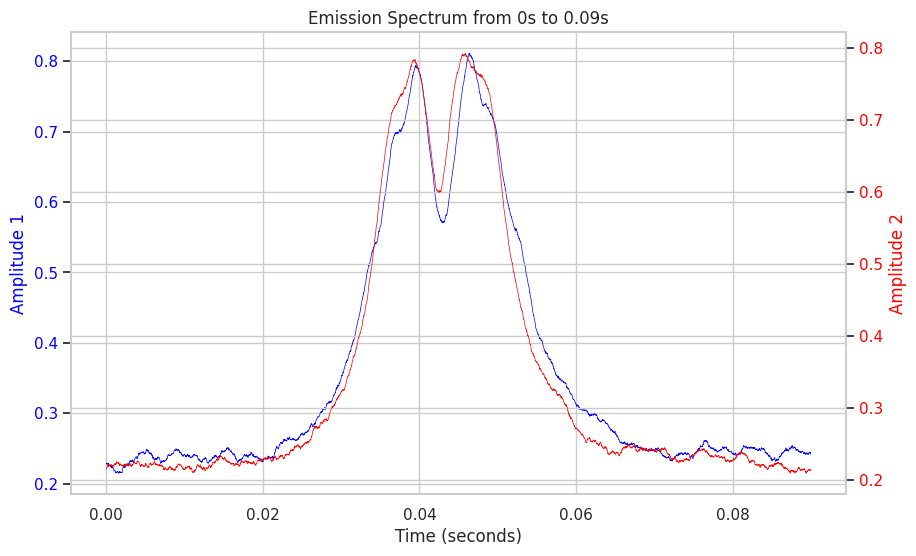

0.20259021250000003 0.3000759675


In [46]:
rand_2 = np.random.choice(range(0,len(peaks)),2)
plot_emission_spectrum(peaks[0], 0.09 , 0 , 0.09, second_array= peaks[rand_2[1]])
print(B_values[rand_2[0]],B_values[rand_2[1]])

In [47]:
peaks.shape

(3680, 5000)

# Save and Export the file

In [48]:

np.save('19.09_int_peaks.npy', peaks)
np.save('19.09_int_B_vals.npy', B_values)